In [1]:
# Cloning Mask_RCNN model
# !git clone https://github.com/matterport/Mask_RCNN.git

In [2]:
# !pip3 install imutils
# !pip install -U scikit-image

In [3]:
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import sys

from sklearn.cluster import KMeans
from scipy import ndimage
import matplotlib.pyplot as plt

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline

from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


In [5]:
# Creating a class for training on labelled data sets

class trashMaskRCNNConfig(Config):
    
    # Giving configuration a recognisable name
    NAME = "Mask_RCNN_config"
    
    # Number of GPUs to use, and number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (normally add + 1 to background)
    # Thus trash + background
    NUM_CLASSES = 1 + 1
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE = 0.006
    
    # Skip detections with <90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # Setting max ground truth instances
    MAX_GT_INSTANCES = 10
        

In [6]:
# Creating TrashMaskRCNNConfig instance
config = trashMaskRCNNConfig()

In [7]:
# Displaying all config values
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
# Building custom trash data set

class TrashDataset (Dataset):
    
    # Loading dataset definitions
    def load_dataset(self, dataset_dir, is_train = True)
    
        # Add classes
        # Only one class to add in our case
        self.add_class("dataset", 1, "Trash")
    
        # 

SyntaxError: invalid syntax (<ipython-input-8-9c2457637332>, line 6)

(768, 1024, 3)


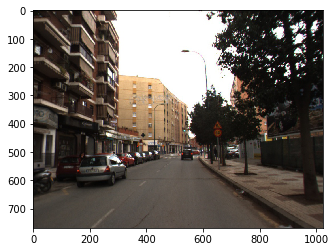

In [60]:


# Image segmentation based on clustering

# Separating image into foregrounds and backgrounds

pic = plt.imread('malaga-13-sorted/andres_trash/img_CAMERA1_1261233382.061621_right.jpg')/255 # Dividing by 255 to bring pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)



In [61]:
# Converting into 2d array to do k-means clustering on

pic_2d = pic.reshape(pic.shape[0] * pic.shape[1], pic.shape[2])
pic_2d.shape


(786432, 3)

In [62]:
# Using kmeans clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(pic_2d)

pic2show = kmeans.cluster_centers_[kmeans.labels_]
print(pic2show.shape)
print(pic2show)
print('\n')

test = kmeans.cluster_centers_
print(test.shape)
print(test)
print('\n')

labels = kmeans.labels_
print(labels.shape)
print(labels)

(786432, 3)
[[0.06600712 0.0583573  0.04819081]
 [0.06600712 0.0583573  0.04819081]
 [0.06600712 0.0583573  0.04819081]
 ...
 [0.300746   0.2588757  0.2273383 ]
 [0.300746   0.2588757  0.2273383 ]
 [0.36484852 0.32493939 0.29184136]]


(10, 3)
[[0.06600712 0.0583573  0.04819081]
 [0.99463414 0.99603915 0.99327119]
 [0.36484852 0.32493939 0.29184136]
 [0.77911169 0.66800215 0.54735666]
 [0.21812749 0.17667023 0.15202649]
 [0.6406898  0.53070206 0.42759461]
 [0.87116983 0.81106446 0.71841874]
 [0.4807221  0.41032747 0.35181772]
 [0.300746   0.2588757  0.2273383 ]
 [0.12893004 0.10675784 0.09094171]]


(786432,)
[0 0 0 ... 8 8 2]


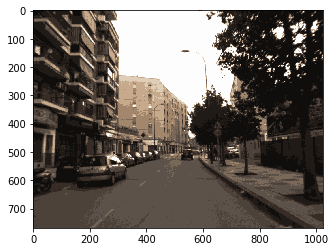

In [63]:
# Reshaping image back to 3d and plotting results
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic, cmap = 'viridis', interpolation='nearest')

[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.12893004 0.10675784 0.09094171]]


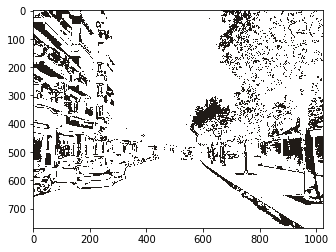

In [66]:
# Grabbing only the foreground

# Choosing only one cluster center by changing the rest to 1, or white
centers = kmeans.cluster_centers_
chosen_center = np.where(centers!= centers[9], 1, centers)
print(chosen_center)

# Grabbing only that cluster
foreground = chosen_center[kmeans.labels_]

# Reshaping image back to 3d and plotting results
foreground_pic = foreground.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(foreground_pic, cmap = 'viridis', interpolation='nearest')

In [67]:
# Defining Laplacian filter for convolution
kernel_laplace = np.array([np.array([1,1,1]), np.array([1, -8, 1]), np.array([1,1,1])])
print(kernel_laplace, 'is a laplacian kernel')

[[ 1  1  1]
 [ 1 -8  1]
 [ 1  1  1]] is a laplacian kernel


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


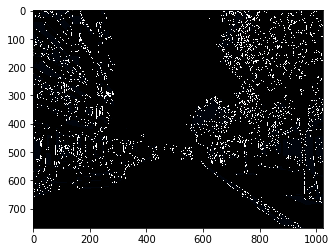

In [68]:
# Convolving over image and then reshaping it back
convolved = ndimage.convolve(foreground, kernel_laplace, mode = 'reflect')

# Reshaping image back to 3d and plotting results
convolved_pic = convolved.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(convolved_pic, cmap = 'viridis', interpolation='nearest')

In [ ]:
# Drawing bounding boxes over convolved features





In [ ]:
# Separate image into foreground and background
# Use Laplacian filter on foreground 